In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def log_likelihood(x, mean, covariance_matrix):
    dim = len(mean)
    det_covariance = np.linalg.det(covariance_matrix)
    inv_covariance = np.linalg.inv(covariance_matrix)
    return - 0.5 * dim * np.log(2*np.pi) - 0.5 * np.log(det_covariance) - 0.5 * (x - mean).T @ inv_covariance @ (x - mean)

# log accpetance rate
def log_acceptance_probability(candidate_x, current_x, mean, covariance):
    return log_likelihood(candidate_x, mean, covariance) - log_likelihood(current_x, mean, covariance)

# proposal distributionn
def proposal_distribution(current_x, proposal_std, cov): 
        re = current_x + proposal_std * np.random.multivariate_normal(np.zeros(len(current_x)), cov)
        return re

def partial_mean(x, mean, cov):
    inv_covariance = np.linalg.inv(cov)
    return  inv_covariance @ (x - mean)

def partial_cov(x, mean, cov):
    inv = np.linalg.inv(cov)
    diff = x - mean
    return - (0.5 * (inv - inv @ np.outer(diff, diff) @ inv))


In [4]:
def MH(num , train_data, pro_std, mean, cov):
    # initialize
    current_x = train_data 
    samples_x = []

    for _ in range(num):
        
        # produce candidate by proposal distribution
        candidate_x = proposal_distribution(current_x, pro_std,  cov)
        a_r = log_acceptance_probability(candidate_x, current_x, mean, cov)
        
        if np.log(np.random.uniform(0,1)) < a_r:
            current_x = candidate_x
        
        samples_x.append(current_x)
    
    return samples_x

In [5]:
def MH_1step(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    cov_1 = []
    cov_2 = []
    initial_state = sample[0]
    num_sample = len(sample)
    
    time_1 = time.time()
    l2 = []

    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        X = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        MSE = ((X - sample) ** 2).mean()
        l2.append(MSE)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        cov_1.append(covariance_matrix_i[0][1])
        cov_2.append(covariance_matrix_i[1][0])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        
    time_2 = time.time()
    time_cost = time_2 - time_1
    return ni, mui, mui1, sigmai, sigmai1,time_cost, cov_1, cov_2, l2

# two dimension (discussion of difference between step size in discussion chapter)

In [8]:
# true value
true_mean = np.array([2.0, 3.0]) 
true_covariance = np.array([[1.0, 0.0], [0.0, 1.0]]) 

sample = np.random.multivariate_normal(true_mean, true_covariance, size=100)
sample_train = sample[1]

In [10]:
# 1 step with mean [1.5,2.5]
eta = 0.1
mean_0= np.array([0.5,5.5])
covariance_matrix_0 = np.array([[0.5,0.0], [0.0,0.5]])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

A = MH_1step(eta, mean_0, covariance_matrix_0, proposal_std, sample, iteration)

cov1: 0.9974143176499006
cov2: 1.0435370780343098


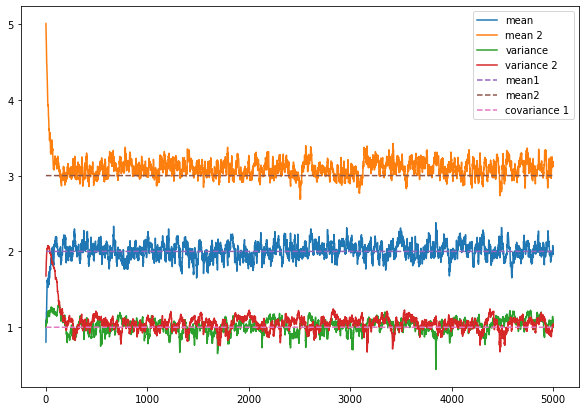

In [11]:
x = []
y = []
x22 = []
for i in range(iteration):
    x1 = true_mean[0]
    x2 = true_mean[1]
    y1 = true_covariance[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)
    
plt.figure(figsize=(10,7))
plt.plot(A[0],A[1],label = 'mean')
plt.plot(A[0],A[2],label = 'mean 2')
plt.plot(A[0],A[3],label = 'variance')
plt.plot(A[0],A[4],label = 'variance 2')
plt.plot(A[0],x, linestyle = '--', label = 'mean1')
plt.plot(A[0],x22, linestyle = '--', label = 'mean2')
plt.plot(A[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = A[3][-1]
last_covvalue2 = A[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()
plt.savefig('1step_2D_0.1stepsize.png')

In [12]:
# step size = 0.01
eta = 0.01
mean_0= np.array([0.5,5.5])
covariance_matrix_0 = np.array([[0.5,0.0], [0.0,0.5]])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

B = MH_1step(eta, mean_0, covariance_matrix_0, proposal_std, sample, iteration)

cov1: 1.0228039344432076
cov2: 1.0071619799773783


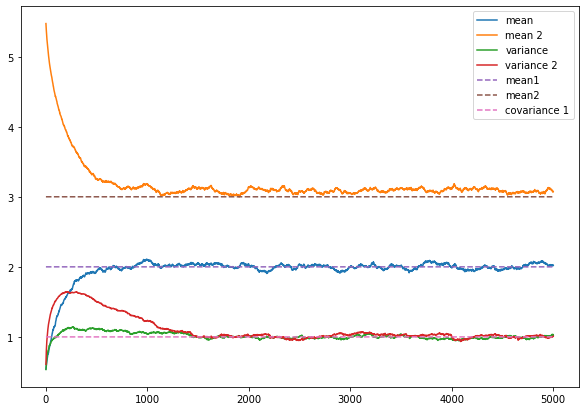

In [13]:
plt.figure(figsize=(10,7))
plt.plot(B[0],B[1],label = 'mean')
plt.plot(B[0],B[2],label = 'mean 2')
plt.plot(B[0],B[3],label = 'variance')
plt.plot(B[0],B[4],label = 'variance 2')
plt.plot(B[0],x, linestyle = '--', label = 'mean1')
plt.plot(B[0],x22, linestyle = '--', label = 'mean2')
plt.plot(B[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = B[3][-1]
last_covvalue2 = B[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()
plt.savefig('1step_2D_0.01stepsize.png')

In [14]:
# step size = 1.0
eta = 1.0
mean_0= np.array([0.5,5.5])
covariance_matrix_0 = np.array([[0.5,0.0], [0.0,0.5]])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

C = MH_1step(eta, mean_0, covariance_matrix_0, proposal_std, sample, iteration)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


cov1: 80.55337592178697
cov2: 123.2920757464991


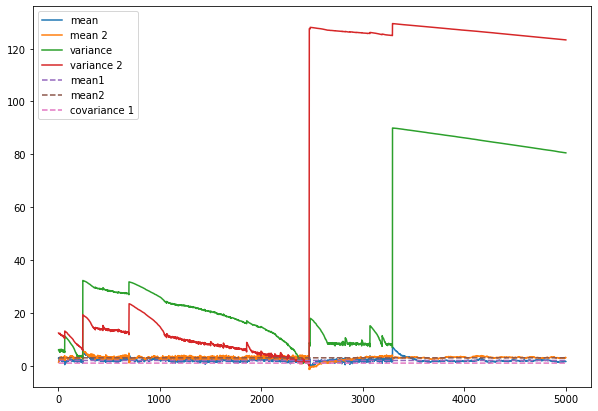

In [15]:
plt.figure(figsize=(10,7))
plt.plot(C[0],C[1],label = 'mean')
plt.plot(C[0],C[2],label = 'mean 2')
plt.plot(C[0],C[3],label = 'variance')
plt.plot(C[0],C[4],label = 'variance 2')
plt.plot(C[0],x, linestyle = '--', label = 'mean1')
plt.plot(C[0],x22, linestyle = '--', label = 'mean2')
plt.plot(C[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = C[3][-1]
last_covvalue2 = C[4][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
plt.legend()
plt.savefig('1step_2D_1stepsize.png')

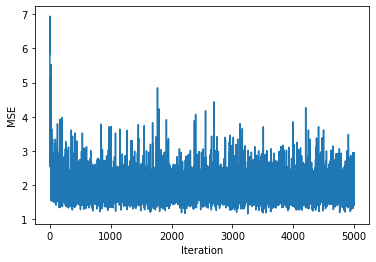

In [24]:
plt.plot(A[0],A[-1])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.savefig('1step_2D_0.1MSE.png')

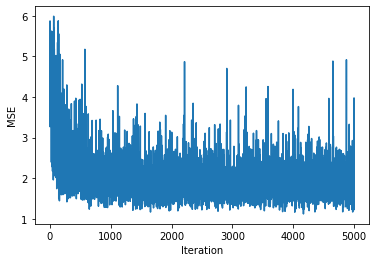

In [25]:
plt.plot(B[0],B[-1])
plt.xlabel('Iteration')
plt.ylabel('MSE')   
plt.savefig('1step_2D_0.01MSE.png')

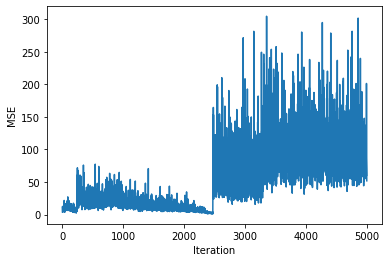

In [26]:
plt.plot(C[0],C[-1])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.savefig('1step_2D_1MSE_1stepsize.png')

# 3 dimension CD definition

In [63]:
# true value
true_mean = np.array([2.0, 4.0, 6.0]) 
true_covariance = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) 

sample = np.random.multivariate_normal(true_mean, true_covariance, size=500)
sample_train = sample[1]
sample_train

array([2.83841588, 2.31273231, 5.58225505])

In [64]:
def MH_1step_3D(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    mui2 = []
    sigmai=[]
    sigmai1 = []
    sigmai2 = []
    initial_state = sample[0]
    num_sample = len(sample)

    L_2_log = []

    time1 = time.time()
    
    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])

        X = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        norm = np.linalg.norm(mean_i[0] - true_mean[0])
        L_2_log.append(np.log(norm))

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mui2.append(mean_i[2])        
        sigmai2.append(covariance_matrix_i[2][2])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        print(mean_i)
    time2 = time.time()
    time_cost = time2 - time1
    return ni, mui, mui1, mui2, sigmai, sigmai1, sigmai2, L_2_log, time_cost

In [71]:
def MH_persistant_3D(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    mui2 = []
    sigmai=[]
    sigmai1 = []
    sigmai2 = []

    initial_state = sample[0]
    num_sample = len(sample)

    L_2_log = []

    time1 = time.time()
    
    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])

        X = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        # persistent part
        initial_state = X[-1]

        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        norm = np.linalg.norm(mean_i[0] - true_mean[0])
        L_2_log.append(np.log(norm))

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mui2.append(mean_i[2])        
        sigmai2.append(covariance_matrix_i[2][2])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        print(mean_i)
    time2 = time.time()
    time_cost = time2 - time1
    return ni, mui, mui1, mui2, sigmai, sigmai1, sigmai2, L_2_log, time_cost

In [66]:
def MH_multistep_3D(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    mui2 = []
    sigmai=[]
    sigmai1 = []
    sigmai2 = []
    initial_state = sample[0]
    num_sample = len(sample)

    L_2_log = []
    time1 = time.time()
    
    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])

        X1 = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        X2 = MH(num_sample, X1[-1], pro, mean_1step, covariance_1tep)
        X3 = MH(num_sample, X2[-1], pro, mean_1step, covariance_1tep)
        X = MH(num_sample, X3[-1], pro, mean_1step, covariance_1tep)
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        norm = np.linalg.norm(mean_i[0] - true_mean[0])
        L_2_log.append(np.log(norm))

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mui2.append(mean_i[2])        
        sigmai2.append(covariance_matrix_i[2][2])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        print(mean_i)
    time2 = time.time()
    time_cost = time2 - time1
    return ni, mui, mui1, mui2, sigmai, sigmai1, sigmai2, L_2_log, time_cost

# Examples of CD method in 3D.

In [43]:
# 1 step with mean [1.5,2.5]
eta = 0.01
mean_0= np.array([3.0,3.0,3.0])
covariance_matrix_0 = np.array([[0.7,0.0,0.0], [0.0,1.5,0.0],[0.0,0.0,2.5]])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

A = MH_1step_3D(eta, mean_0, covariance_matrix_0, proposal_std, sample, iteration)

[2.98746259 3.00870027 3.01090306]
[2.97480252 3.01533575 3.02246381]
[2.96233864 3.02107853 3.03328102]
[2.9495371  3.02671509 3.0443431 ]
[2.93756177 3.03279341 3.05778491]
[2.92529993 3.03861203 3.07013385]
[2.91991447 3.04686341 3.08160499]
[2.90666183 3.05128046 3.0932811 ]
[2.90015227 3.05861371 3.10389283]
[2.88861113 3.06181399 3.11424949]
[2.88309056 3.06612177 3.12568269]
[2.87057187 3.07045721 3.13770822]
[2.85666279 3.07797956 3.14795734]
[2.85088752 3.07839816 3.15877739]
[2.84249793 3.08215043 3.17018612]
[2.83476291 3.08877011 3.18094786]
[2.82417913 3.09143475 3.1909638 ]
[2.81644881 3.09783113 3.20260803]
[2.80671297 3.10525892 3.21132633]
[2.80436978 3.10922997 3.223773  ]
[2.79786927 3.1123219  3.23360184]
[2.78393887 3.11658661 3.24374327]
[2.7785948 3.1206748 3.2518189]
[2.77521988 3.12779914 3.26235101]
[2.76568333 3.13338912 3.27342242]
[2.75911829 3.13875516 3.28585638]
[2.75423516 3.14236006 3.29624019]
[2.74735678 3.14539056 3.30609781]
[2.74536952 3.15101057 

cov1: 0.8862568309746539
cov2: 0.973834497948383
cov3: 0.9386719939140803


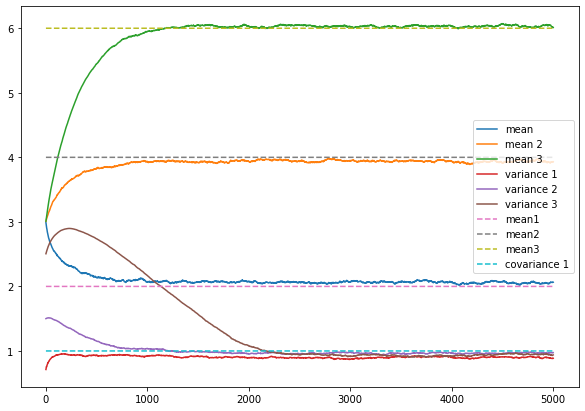

In [45]:
x = []
y = []
x22 = []
x33 = []
for i in range(iteration):
    x1 = true_mean[0]
    x2 = true_mean[1]
    x3 = true_mean[2]
    y1 = true_covariance[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)
    x33.append(x3)

plt.figure(figsize=(10,7))
plt.plot(A[0],A[1],label = 'mean')
plt.plot(A[0],A[2],label = 'mean 2')
plt.plot(A[0],A[3],label = 'mean 3')
plt.plot(A[0],A[4],label = 'variance 1')
plt.plot(A[0],A[5],label = 'variance 2')
plt.plot(A[0],A[6],label = 'variance 3')
plt.plot(A[0],x, linestyle = '--', label = 'mean1')
plt.plot(A[0],x22, linestyle = '--', label = 'mean2')
plt.plot(A[0],x33, linestyle = '--', label = 'mean3')
plt.plot(A[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = A[4][-1]
last_covvalue2 = A[5][-1]
last_covvalue3 = A[6][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
print("cov3:", last_covvalue3)
plt.legend()
plt.savefig('1step_CD_uncon_3D.png')

In [72]:
eta = 0.01
mean_0= np.array([5,3,1])
covariance_matrix_0 = np.array([[0.5,0.0,0.0], [0.0,0.8,0.0],[0.0,0.0,1.5]])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

B = MH_persistant_3D(eta, mean_0, covariance_matrix_0, proposal_std, sample, iteration)

[4.94057004 3.01197493 1.03341135]
[4.90142069 3.02140217 1.06423923]
[4.86987942 3.02636538 1.09374446]
[4.84307749 3.03036275 1.1191744 ]
[4.8166935  3.03371105 1.14086348]
[4.79775027 3.04223223 1.16445981]
[4.7789841  3.04768704 1.18880183]
[4.75650625 3.05351972 1.21055715]
[4.73965335 3.05644019 1.23439596]
[4.71904466 3.06239681 1.25985461]
[4.6970962  3.06895991 1.27696335]
[4.67924869 3.07601784 1.2970126 ]
[4.66408487 3.08229927 1.32002267]
[4.64579862 3.09143734 1.33769207]
[4.62932666 3.09545058 1.35627417]
[4.61154108 3.10054079 1.37501528]
[4.59593904 3.10423278 1.39502013]
[4.58666957 3.10350733 1.41732727]
[4.57603735 3.11275666 1.43556191]
[4.56061554 3.11130477 1.45327802]
[4.54898118 3.12262634 1.47423336]
[4.53590494 3.12509339 1.49227242]
[4.52677179 3.12818423 1.50823816]
[4.51121821 3.12499878 1.52600219]
[4.49745376 3.13121469 1.54514537]
[4.48605216 3.13707828 1.56260138]
[4.47739465 3.1431038  1.58264358]
[4.46963393 3.14192821 1.60046711]
[4.45618373 3.143509

cov1: 0.9498672510485333
cov2: 1.0945635141341155
cov3: 0.9415396883975518


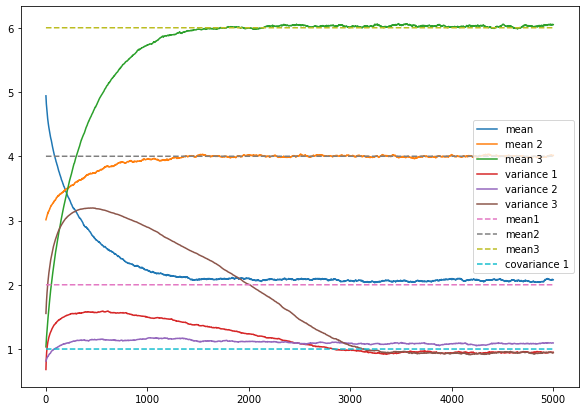

In [74]:
x = []
y = []
x22 = []
x33 = []
for i in range(iteration):
    x1 = true_mean[0]
    x2 = true_mean[1]
    x3 = true_mean[2]
    y1 = true_covariance[0][0]
    x.append(x1)
    y.append(y1)
    x22.append(x2)
    x33.append(x3)

plt.figure(figsize=(10,7))
plt.plot(B[0],B[1],label = 'mean')
plt.plot(B[0],B[2],label = 'mean 2')
plt.plot(B[0],B[3],label = 'mean 3')
plt.plot(B[0],B[4],label = 'variance 1')
plt.plot(B[0],B[5],label = 'variance 2')
plt.plot(B[0],B[6],label = 'variance 3')
plt.plot(B[0],x, linestyle = '--', label = 'mean1')
plt.plot(B[0],x22, linestyle = '--', label = 'mean2')
plt.plot(B[0],x33, linestyle = '--', label = 'mean3')
plt.plot(B[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = B[4][-1]
last_covvalue2 = B[5][-1]
last_covvalue3 = B[6][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
print("cov3:", last_covvalue3)
plt.legend()
plt.savefig('persistent_CD_uncon_3D.png')

In [48]:
eta = 0.01
mean_0= np.array([1.5,1.5,1.5])
covariance_matrix_0 = np.array([[1.2,0.0,0.0], [0.0,1.2,0.0],[0.0,0.0,1.2]])
# proposal Standard deviation
proposal_std = 0.5
iteration = 5000

C = MH_multistep_3D(eta, mean_0, covariance_matrix_0, proposal_std, sample, iteration)

[1.50618374 1.51946086 1.53629354]
[1.50964568 1.53900361 1.57363802]
[1.51260288 1.558489   1.60928296]
[1.51883828 1.57683631 1.6400317 ]
[1.51894201 1.59594149 1.66748036]
[1.52494882 1.61091785 1.6931829 ]
[1.53021889 1.62540271 1.72116184]
[1.53023268 1.64132463 1.74812632]
[1.53269424 1.65479393 1.77340092]
[1.53593823 1.66811056 1.79960311]
[1.53534875 1.68341102 1.82376817]
[1.53883922 1.69564907 1.84611862]
[1.5428785  1.70869941 1.86876204]
[1.54679003 1.72118679 1.88829675]
[1.54963624 1.73182684 1.91263191]
[1.55221757 1.7418703  1.93502321]
[1.55071423 1.75263842 1.95680334]
[1.55242255 1.7650191  1.97828183]
[1.55451261 1.77461331 1.99974275]
[1.55966579 1.78242164 2.02533652]
[1.56023755 1.79378982 2.04674892]
[1.56063827 1.80484243 2.06639869]
[1.56027106 1.81626042 2.08507111]
[1.56290935 1.82836686 2.09928895]
[1.56353011 1.83731324 2.11528627]
[1.56858446 1.84636266 2.13046624]
[1.57195392 1.85463733 2.14851504]
[1.57369364 1.8634132  2.16401707]
[1.57814448 1.874821

cov1: 0.8979365576661349
cov2: 0.9660269359323174
cov3: 0.9238838697655776


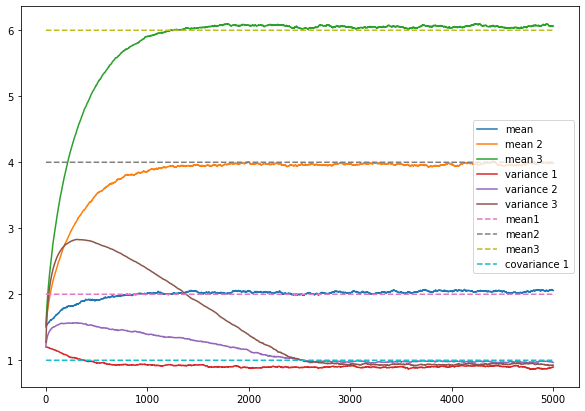

In [50]:
# the multistep method graph
plt.figure(figsize=(10,7))
plt.plot(C[0],C[1],label = 'mean')
plt.plot(C[0],C[2],label = 'mean 2')
plt.plot(C[0],C[3],label = 'mean 3')
plt.plot(C[0],C[4],label = 'variance 1')
plt.plot(C[0],C[5],label = 'variance 2')
plt.plot(C[0],C[6],label = 'variance 3')
plt.plot(C[0],x, linestyle = '--', label = 'mean1')
plt.plot(C[0],x22, linestyle = '--', label = 'mean2')
plt.plot(C[0],x33, linestyle = '--', label = 'mean3')
plt.plot(C[0],y, linestyle = '--', label = 'covariance 1')
last_covvalue1 = C[4][-1]
last_covvalue2 = C[5][-1]
last_covvalue3 = C[6][-1]
print("cov1:", last_covvalue1)
print("cov2:", last_covvalue2)
print("cov3:", last_covvalue3)
plt.legend()
plt.savefig('multistep_CD_uncon_3D.png')